# TEAM 2
## MARVIN MORAN, MURIS SAAB, RAVITA KARTAWINATA
## ADS 507 - DATA ENGINEERING

# COCKTAIL DATABASE PIPELINE
This project is to construct a database schema and pipeline for non-alcohol and alcohol beverages with four datasets with ETL approach that would store a final dataset in Azure/ Test Database which will be used to perform EDA

## Loading Libraries and DB access parameters

In [20]:
import pandas as pd
import mysql.connector
import sqlalchemy
from sqlalchemy import  text, MetaData
import requests
import sqlite3
import json
import seaborn as sns
from matplotlib import pyplot as plt

# parameter in local database/ test
userName = 'Ravi'
userPass = 'password'
host='localhost'
port=3306
database='test'

"""
# parameter in local database/ test
userName = 'ravi'
userPass = 'Password507'
host='sakila-2.mysql.database.azure.com'
port=3306
database='test'
"""

"\n# parameter in local database/ test\nuserName = 'ravi'\nuserPass = 'Password507'\nhost='sakila-2.mysql.database.azure.com'\nport=3306\ndatabase='test'\n"

## Step 1: Retrieve Data from API (Json Files) and CSV files
API JSON files of Drink and Glass are originated from https://www.thecocktaildb.com/api.php. There two datasets are from API. Another 2 datasets of Category and Ingredient come from CSV files

In [21]:
# CSV datasource - list of category(c), ingredient(i)
df_category_csv = pd.read_csv('C:/Users/rkartawi/Desktop/Ravita/MSADS/507/ADS507/category.csv')
df_ingrident_csv = pd.read_csv('C:/Users/rkartawi/Desktop/Ravita/MSADS/507/ADS507/ingredient.csv')

#Display data
df_category_csv.head()
df_ingrident_csv.head()

,strIngredient1,strCountryofOrigin
0,Light rum,Caribbean
1,Applejack,United States
2,Gin,Netherlands
3,Dark rum,Caribbean
4,Sweet Vermouth,Italy


In [22]:
#API Search cocktails by first letter and load all first characters
all_drinks = []
for letter in 'abcdefghijklmnopqrstvwyz12345679%':
    # Make the API request with the current letter
    response = requests.get(f"https://www.thecocktaildb.com/api/json/v1/1/search.php?f={letter}")
    # Get the JSON data from the response
    data = response.json()
    # Append the 'drinks' data from the response to the list
    all_drinks.extend(data['drinks'])
df = pd.DataFrame(all_drinks)

response_glass = requests.get(f"https://www.thecocktaildb.com/api/json/v1/1/list.php?g=list")
data_glass = response_glass.json()
df_glass = pd.DataFrame(data_glass['drinks'])

## Step 2: Data Cleanup
Drink JSON file has many unnecessary attributes that are not useful for Drink Table

In [23]:
# Remove unneccessary columns from drink
columns_to_drop = ['strDrinkAlternate', 'strTags', 'strVideo', 'strIBA',
                   'strInstructionsES', 'strInstructionsDE', 'strInstructionsFR', 'strInstructionsIT', 
                   'strInstructionsZH-HANS', 'strInstructionsZH-HANT', 'strDrinkThumb', 
                   'strIngredient4', 'strIngredient5', 'strIngredient6', 'strIngredient7', 'strIngredient8',
                   'strIngredient9', 'strIngredient10', 'strIngredient11', 'strIngredient12', 'strIngredient13', 
                    'strIngredient14', 'strIngredient15', 'strMeasure1', 'strMeasure2', 'strMeasure3', 'strMeasure4',	
                    'strMeasure5', 'strMeasure6', 'strMeasure7', 'strMeasure8', 'strMeasure9', 'strMeasure10',
                    'strMeasure11', 'strMeasure12', 'strMeasure13', 'strMeasure14', 'strMeasure15', 'strImageSource',
                    'strImageAttribution', 'strCreativeCommonsConfirmed'
                    ]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
 

## Step 3: SQL

### Step 3a: Connect to AZURE/ TEST Database

In [24]:
# create engine to execute 
engine = sqlalchemy.create_engine(f"mysql+mysqlconnector://{userName}:{userPass}@{host}:{port}/{database}")

### Step 3b: Create Table in TEST Database

In [25]:
# Create Tables Queries
Create_category_table_q =   """
                            CREATE TABLE test.category (
                            strCategory VARCHAR(50) NOT NULL,
                            strDescription VARCHAR(150) NOT NULL,
                            PRIMARY KEY (strCategory)); 
                            """

Create_ingredient_table_q = """
                            CREATE TABLE test.ingredient (
                            strIngredient1 VARCHAR(50) NOT NULL,
                            strCountryofOrigin VARCHAR(150) NOT NULL,
                            PRIMARY KEY (strIngredient1));
                            """

Create_glass_table_q = """
                        CREATE TABLE test.glass (
                        strGlass VARCHAR(50) NOT NULL,
                        PRIMARY KEY (strGlass));
                        """

Create_drink_table_q = """
                        CREATE TABLE test.drink (
                        idDrink INT NOT NULL,
                        strDrink VARCHAR(150),
                        strCategory VARCHAR(50),
                        strAlcoholic VARCHAR(50),
                        strGlass VARCHAR(50),
                        strInstructions VARCHAR(250),
                        strIngredient1 VARCHAR(50),
                        strIngredient2 VARCHAR(50),
                        strIngredient3 VARCHAR(50),
                        dateModified DATETIME,
                        PRIMARY KEY (idDrink));
                        """

In [33]:
# Execute "Create TABLE" queries
with engine.connect() as conn:
  result = conn.execute(text(Create_category_table_q))
  print("Table 'Category' created successfully.")

  result = conn.execute(text(Create_ingredient_table_q))
  print("Table 'Ingredient' created successfully.")

  result = conn.execute(text(Create_glass_table_q))
  print("Table 'Glass' created successfully.")

  result = conn.execute(text(Create_drink_table_q))
  print("Table 'Drink' created successfully.")

Table 'Category' created successfully.
Table 'Ingredient' created successfully.
Table 'Glass' created successfully.
Table 'Drink' created successfully.


### Step 3c: Load transformed data to SQL Tables
Clean-up data from JSON Files and CSV files are stored in mySQL tables

In [27]:
# Load DataFrame from CSV and API Json Files into Azure MySQL table
df_category_csv.to_sql('category', con=engine, if_exists='replace', index=False)
df_ingrident_csv.to_sql('ingredient', con=engine, if_exists='replace', index=False)
df_glass.to_sql('glass', con=engine, if_exists='replace', index=False)
df.to_sql('drink', con=engine, if_exists='replace', index=False)

466

## Step 4: Data Queries and Plots
Perform data queries from drink with relationship to Ingredient

### Step 4a: Data Query by Category

User searched for Ingredient: Vodka
option: Ingredient
user_input: Vodka
Search count: 72
SELECT count(*) as count, strCategory
                        FROM drink
                        WHERE strIngredient1 like '%Vodka%' 
                        or strIngredient2 like '%Vodka%'
                        or strIngredient3 like '%Vodka%'
                        GROUP BY strCategory


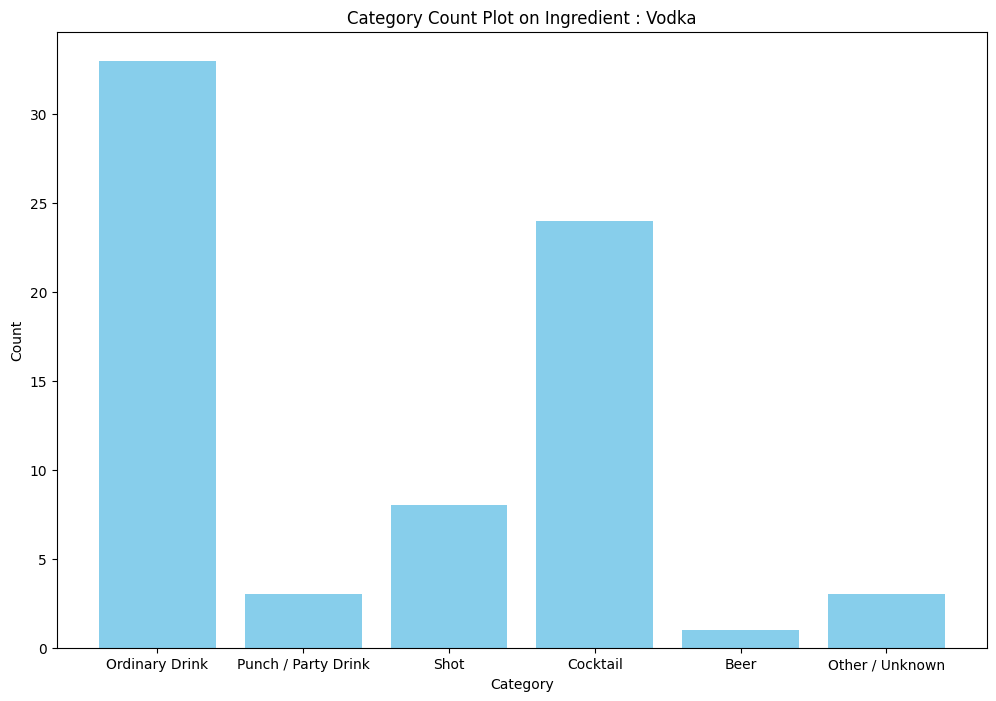

In [29]:
import tkinter as tk
from tkinter import simpledialog
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

global_user_input = None
global_option = None

def show_popup(option):
    global global_user_input, global_option
    
    # Ask the user for input with a pop-up window
    user_input = simpledialog.askstring("Input", f"Enter {option}:")
    
    # Check if the user clicked Cancel or entered a value
    if user_input is not None:
        result_label.config(text=f"User searched for {option}: {user_input}")
        global_user_input = user_input
        global_option = option
        print(f"User searched for {option}: {user_input}")
        root.destroy()

    else:
        result_label.config(text=f"User clicked Cancel for {option}")

# Create the main window
root = tk.Tk()
root.title("Button Selection")

# Create buttons to trigger the pop-up for "Glass Type", "Alcohol Type", "Drink Category"
button_font = ("Arial", 12)  # Adjust the font size as needed

#glass_type_button = tk.Button(root, text="Glass Type", font=button_font, command=lambda: show_popup("Glass"), width=20, height=2)
#glass_type_button.grid(row=1, column=0, padx=10)

ingredient_button = tk.Button(root, text="Ingredient", font=button_font, command=lambda: show_popup("Ingredient"), width=20, height=2)
ingredient_button.grid(row=1, column=3, padx=10)

# Create a label to display the result
result_label = tk.Label(root, text="")
result_label.grid(row=2, column=0, columnspan=4, pady=10)

# Start the Tkinter event loop
root.mainloop()

# Access global_user_input and global_option outside the Tkinter event loop
if global_user_input is not None and global_option is not None:
    print("option:", global_option)
    print("user_input:", global_user_input)

# STARTING THE QUERY FOR TABLE OR LIST BY INGREDIENT OR GLASS
if global_option == "Ingredient":
    count_query = text(f"""SELECT count(*) FROM drink 
                       WHERE strIngredient1 like '%{global_user_input}%'
                        or strIngredient2 like '%{global_user_input}%'
                        or strIngredient3 like '%{global_user_input}%'""")
    select_query = text(f"""SELECT strDrink, strCategory, strGlass, strAlcoholic, 
                        strIngredient1, strIngredient2, strIngredient3, strInstructions
                        FROM drink 
                        WHERE strIngredient1 like '%{global_user_input}%' 
                        or strIngredient2 like '%{global_user_input}%'
                        or strIngredient3 like '%{global_user_input}%'""")
else:
    global_user_input = global_user_input+" glass"
    count_query = text(f"SELECT count(*) FROM cocktail WHERE strglass = '{global_user_input}'")
    select_query = text(f"""SELECT strDrink, strCategory, strGlass, strAlcoholic, 
                        strIngredient1, strIngredient2, strIngredient3, strInstructions
                        FROM cocktail WHERE strglass = '{global_user_input}'""")
#print(select_query)
# Execute the SELECT query
with engine.connect() as conn:
    count = conn.execute(count_query)
    count_result = count.scalar()
    
    result = conn.execute(select_query)
    rows = result.fetchall()

#Display the result
print(f"Search count: {count_result}")
df_query = pd.DataFrame(rows, columns=result.keys())
df_query

# QUERY FOR THE PLOT BY CATEGORY
if global_option == "Ingredient":
    plot_query = text(f"""SELECT count(*) as count, strCategory
                        FROM drink
                        WHERE strIngredient1 like '%{global_user_input}%' 
                        or strIngredient2 like '%{global_user_input}%'
                        or strIngredient3 like '%{global_user_input}%'
                        GROUP BY strCategory""")
else:
    plot_query = text(f"""SELECT count(*) as count, strCategory
                        FROM drink
                        WHERE strGlass like '%{global_user_input}%' 
                        GROUP BY strCategory""")
    
print(plot_query)
with engine.connect() as conn:
    result = conn.execute(plot_query)
    rows = result.fetchall()

#Display the result
df_query = pd.DataFrame(rows, columns=result.keys())
#df_query

# Plotting the bar chart by Category
fig = plt.figure(figsize=(12, 8))
plt.bar(df_query['strCategory'], df_query['count'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title(f"Category Count Plot on {global_option} : {global_user_input}")
#plt.show()

# GUI RESULT
def display_dataframe():
    root = tk.Tk()
    root.title("DataFrame Result")

    tree = ttk.Treeview(root)
    tree["columns"] = list(df_query.columns)
    tree["show"] = "headings"

    for column in df_query.columns:
        tree.heading(column, text=column)

    for index, row in df_query.iterrows():
        tree.insert("", "end", values=list(row))

    tree.pack(expand=True, fill="both")
    # Create a canvas to display the plot
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
    canvas.get_tk_widget().pack()

    root.mainloop()

# Call the function to display the DataFrame in GUI
display_dataframe()

### Step 4b: Join Data Query by Country of Origin

In [30]:
# Query by Ingredient country origin
if global_option == "Ingredient":
    plot_query = text(f"""SELECT count(*) as count, i.strCountryofOrigin
                        FROM drink d
                        JOIN ingredient i ON i.strIngredient1 = d.strIngredient1
                        or i.strIngredient1 = d.strIngredient2
                        or i.strIngredient1 = d.strIngredient3
                        WHERE d.strIngredient1 like '%{global_user_input}%' 
                        or d.strIngredient2 like '%{global_user_input}%'
                        or d.strIngredient3 like '%{global_user_input}%'
                        GROUP BY i.strCountryofOrigin""")
else:
    plot_query = text(f"""SELECT count(*) as count, strGlass
                        FROM drink 
                        WHERE strglass like '%{global_user_input}%' 
                        GROUP BY strGlass""")
#print(plot_query)
with engine.connect() as conn:
    result = conn.execute(plot_query)
    rows = result.fetchall()

#Display the result
df_query = pd.DataFrame(rows, columns=result.keys())
df_query

SELECT count(*) as count, i.strCountryofOrigin
                        FROM drink d
                        JOIN ingredient i ON i.strIngredient1 = d.strIngredient1
                        or i.strIngredient1 = d.strIngredient2
                        or i.strIngredient1 = d.strIngredient3
                        WHERE d.strIngredient1 like '%Vodka%' 
                        or d.strIngredient2 like '%Vodka%'
                        or d.strIngredient3 like '%Vodka%'
                        GROUP BY i.strCountryofOrigin


,count,strCountryofOrigin
0,6,Netherlands
1,15,United States
2,63,Russia
3,20,Various
4,8,France
5,6,Mexico
6,7,Italy
7,1,China
8,1,England
9,7,Caribbean


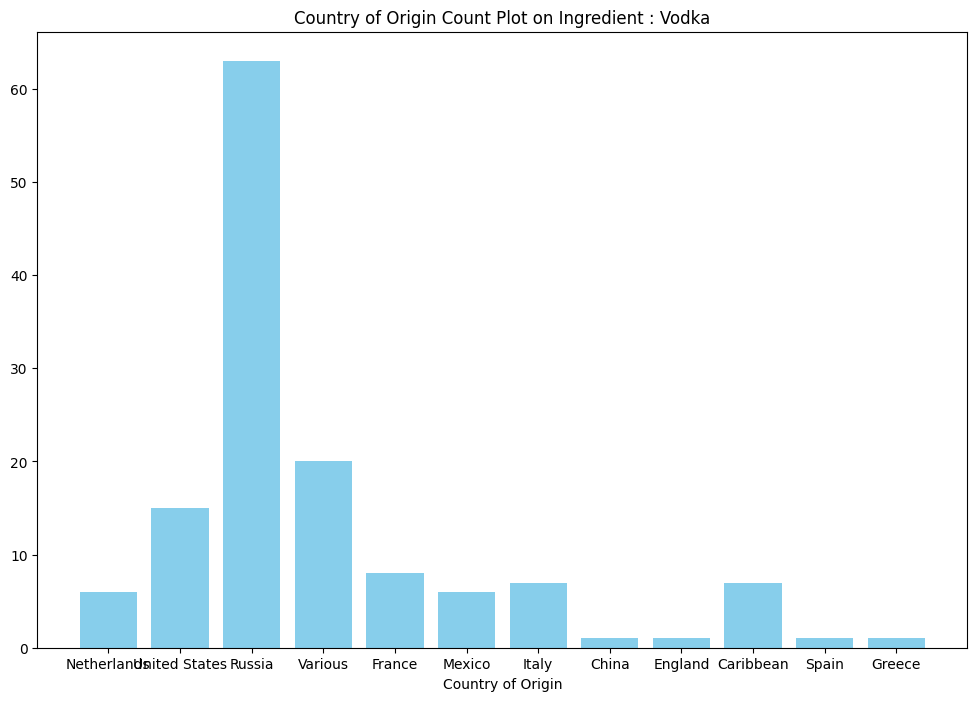

In [31]:
# plot by Country origin
fig = plt.figure(figsize=(12, 8))
# Pivot the DataFrame to prepare for grouped bar chart
if global_option == "Ingredient":
    plt.bar(df_query['strCountryofOrigin'], df_query['count'], color='skyblue')
    plt.xlabel('Country of Origin')
    plt.title(f"Country of Origin Count Plot on {global_option} : {global_user_input}")
else:
    plt.bar(df_query['strGlass'], df_query['count'], color='skyblue')
    plt.xlabel('Glass Type')
    plt.title(f"Glass Type Count Plot on {global_option} : {global_user_input}")

plt.show()

## Step 5: Close Connection and Engine

In [32]:
# Close the conn, engine
conn.close()
engine.dispose()